<a href="https://colab.research.google.com/github/josearangos/Default-of-credit-card-client/blob/master/P2_Experiments_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kaggle** 

kernel con normalización https://www.kaggle.com/selener/prediction-of-credit-card-default



kernels: https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook



Sobre Matrix de confusion y selección de variables 
https://www.kaggle.com/gpreda/default-of-credit-card-clients-predictive-models


# **Experimentos**

Incluya una sesion dentro de su informe con el nombre Experimentos, en la cual describa la metodología de validacion usada y la base de datos que est  ́ a usandó para llevar a cabo el proyecto, incluyendo la fuente de la base de datos como referencia, el numero de muestras,variables, etc. Si su problema es de clasificacion, indique cuantas clases contiene la basa de datos y cu  ́ antas muestras por clase. Si la base de datos esta desbalanceada,deben considerar el uso de tecnicas de submuestreo y sobremuestreo inteligente, ademas de usar validacíón ́estratificaida.

In [0]:
from pandas import DataFrame, read_csv
import pickle
from sklearn.externals import joblib #Guardar modelos una vez entrenados
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc


PATH = '/content/drive/My Drive/2019-1/Simulation of System and Laboratory/Final Project/Code/'

In [0]:
file = PATH+'UCI_Credit_Card.csv'
df = pd.read_csv(file)

# Sobre la base de datos

In [28]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
15057,15058,230000.0,1,1,1,37,-2,-2,-2,-2,-2,-2,211.0,162.0,155.0,155.0,75.0,635.0,162.0,155.0,155.0,75.0,635.0,2336.0,0
22839,22840,120000.0,2,3,1,38,0,0,0,0,0,0,111098.0,114863.0,118038.0,118805.0,59210.0,61267.0,5600.0,6500.0,5000.0,3000.0,3000.0,3000.0,0
10635,10636,90000.0,2,2,2,24,0,0,0,0,-2,-2,80699.0,68100.0,33434.0,0.0,0.0,0.0,2991.0,2655.0,0.0,0.0,0.0,0.0,0
27923,27924,200000.0,2,1,2,26,0,0,0,0,-2,-2,196168.0,201190.0,200662.0,-1528.0,-1528.0,-1504.0,8800.0,10183.0,1504.0,0.0,24.0,204395.0,0
1612,1613,190000.0,2,3,1,38,0,0,0,0,0,0,89619.0,103095.0,110000.0,115674.0,121313.0,15538.0,15000.0,10000.0,5674.0,11313.0,5538.0,18272.0,0


## **Variables**
**SEX: Gender**
1 = male 
2 = female

**EDUCATION:**

1 = graduate school 
2 = university 
3 = high school 
4 = others 
5 = unknown 
6 = unknown






**MARRIAGE**: Marital status
1 = married
2 = single
3 = others



**PAY_0,2,3,4,5,6: **Repayment status in September 2005, August 2005, July 2005, June 2005, May 2005, April 2005 (respectivey)

-2= no consumption
-1= pay duly
1 = payment delay for one month
2 = payment delay for two months
... 
8 = payment delay for eight months
9 = payment delay for nine months and above


**Cantidad de muestras**

In [29]:
df = df.rename(columns={'default.payment.next.month': 'def_pay', 
                        'PAY_0': 'PAY_1'})
data = df.values
data.shape

(30000, 25)

Cantidad de clases

In [30]:
len(np.unique(df.def_pay))

2

Muestras por clases

In [31]:
classes = np.unique(df.def_pay)
unicos = data[:,-1]
unos = np.where(unicos == 1)
lenU =len(unos[0])
cero = np.where(unicos == 0)
lenC=len(cero[0])
print("Clase (1):",lenU)
print("Clase (0):",lenC)

Clase (1): 6636
Clase (0): 23364


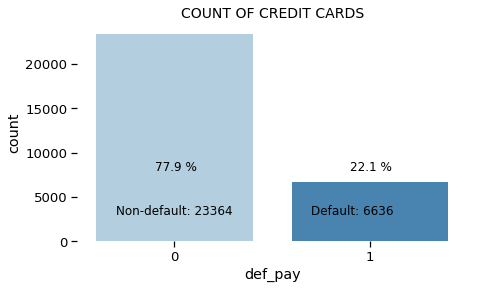

In [32]:
# The frequency of defaults
yes = df.def_pay.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(df)*100, 1)
no_perc = round(no/len(df)*100, 1)

import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('def_pay',data=df, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('COUNT OF CREDIT CARDS', size=14)
#Removing the frame
plt.box(False);

Cantidad de variables y su significado

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null float64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null float64
BILL_AMT2    30000 non-null float64
BILL_AMT3    30000 non-null float64
BILL_AMT4    30000 non-null float64
BILL_AMT5    30000 non-null float64
BILL_AMT6    30000 non-null float64
PAY_AMT1     30000 non-null float64
PAY_AMT2     30000 non-null float64
PAY_AMT3     30000 non-null float64
PAY_AMT4     30000 non-null float64
PAY_AMT5     30000 non-null float64
PAY_AMT6     30000 non-null float64
def_pay      30000 non-null int64
dtypes: float64

## **Feature engineering**

Los datos ya se han codificado y limpiado. Sin embargo, algunos datos categóricos tienen categorías repetidas. Por ejemplo, la variable "educación" tiene tres categorías con información similar: 4: others, 5: unknown, and 6: unknown

Por lo tanto  Las categorías 4: otras, 5: desconocidas y 6: desconocidas se pueden agrupar en una sola clase '4'.
  

In [33]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [34]:
#Reemplazamos los valores 

df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])

df['EDUCATION'].unique()



array([2, 1, 3, 4])

la columna 'matrimonio' ​​debe tener tres categorías: 1 = casado, 2 = soltero, 3 = otros, pero contiene una categoría '0' que se unirá a la categoría '3'.

In [35]:
df['MARRIAGE'].unique()


array([1, 2, 3, 0])

In [36]:
df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])
df['MARRIAGE'].unique()

array([1, 2, 3])

# **Escala de las variables, por lo tanto debemos normalizar**


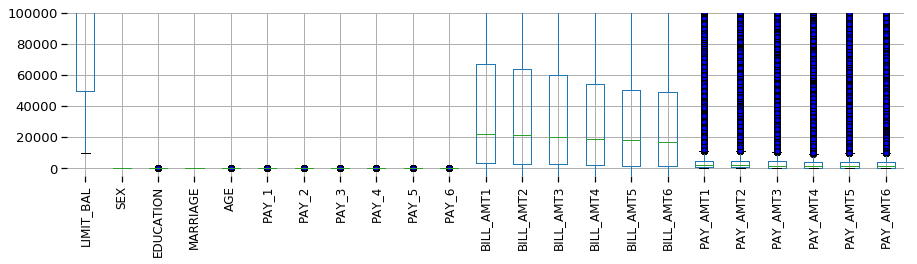

In [37]:

## data are distributed in a wide range (below), need to be normalizded.
df.drop('ID', axis = 1, inplace =True) # drop column "ID"
features = df.drop('def_pay', axis = 1, inplace = False)
plt.figure(figsize=(15,3))
ax= df.drop('def_pay', axis=1).boxplot(df.columns.name, rot=90)
outliers = dict(markerfacecolor='b', marker='p')
ax= features.boxplot(features.columns.name, rot=90, flierprops=outliers)
plt.xticks(size=12)
ax.set_ylim([-5000,100000])
plt.box(False);


**Creamos la variable a predecir**

In [0]:
Y = df['def_pay'].copy()


# **Normalización**

## **StandardScaler**

The standard score of a sample x is calculated as:

z = (x - u) / s

La idea detrás de StandardScaler es que transformará sus datos de modo que su distribución tenga un valor medio 0 y una desviación estándar de 1.




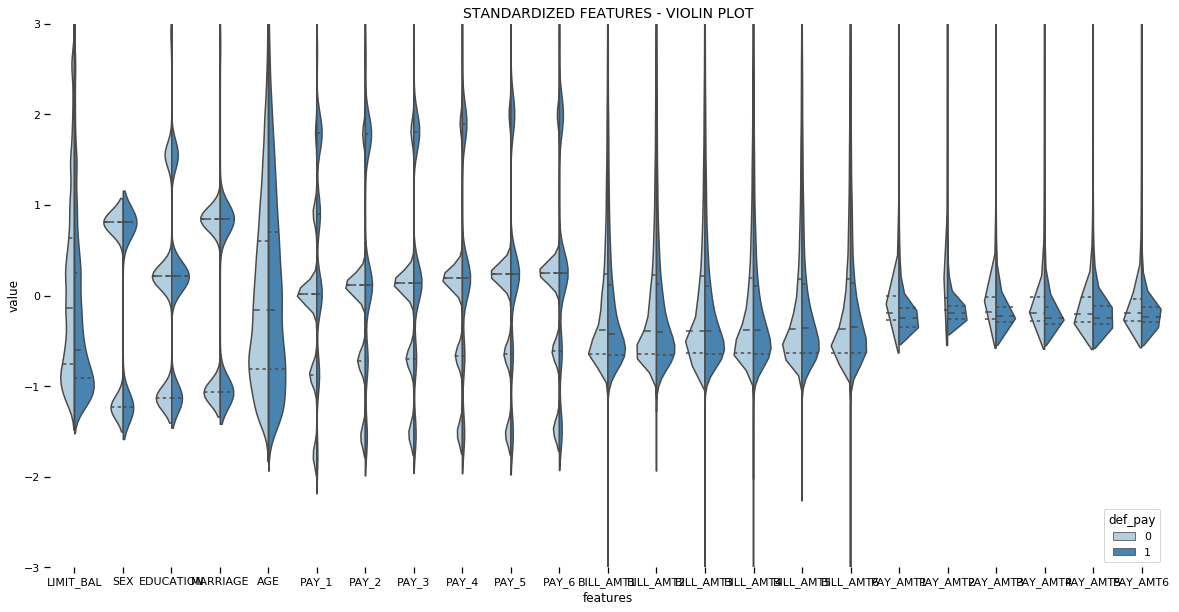

In [39]:
  # standardization

stdX = (features - features.mean()) / (features.std())    
X = stdX
data_st = pd.concat([Y,stdX.iloc[:,:]],axis=1)
data_st = pd.melt(data_st,id_vars="def_pay",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,10))
sns.set_context('notebook', font_scale=1)
sns.violinplot(y="value", x="features", hue="def_pay", data=data_st,split=True, 
               inner="quart", palette='Blues')
plt.legend(loc=4, title= 'def_pay', facecolor='white')
plt.ylim([-3,3])
plt.title('STANDARDIZED FEATURES - VIOLIN PLOT', size=14)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=False);

# **Variables Normalizadas**

In [40]:
stdX.sample(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
17023,-0.751338,0.810147,-1.131327,0.849116,-1.354484,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.591496,-0.566235,-0.532610,-0.498345,-0.476855,-0.459830,-0.251374,-0.191884,-0.205923,-0.269758,-0.281405,-0.259627
10971,1.329625,0.810147,-1.131327,-1.068779,-0.269638,0.014860,0.111734,0.138862,-1.521918,-0.647554,-0.616441,-0.210880,-0.115985,-0.677917,-0.672486,-0.536611,-0.296735,0.021398,-0.256985,-0.296796,0.182618,1.073458,0.302883
12118,-0.134756,0.810147,0.211866,0.849116,-1.029030,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.202637,-0.226475,-0.187819,-0.126700,-0.062164,-0.042428,-0.216961,-0.083598,-0.119991,-0.145925,-0.094997,-0.179244
2270,-0.751338,0.810147,0.211866,0.849116,-1.354484,-0.874977,0.111734,0.138862,0.188743,0.234913,0.253133,-0.653776,-0.629573,-0.543050,-0.434940,-0.327505,-0.435852,-0.251374,-0.024659,0.059994,0.096764,-0.179626,-0.110168
4123,-0.365974,0.810147,0.211866,-1.068779,0.489753,-1.764813,-1.558850,-1.532166,-0.666588,0.234913,0.253133,0.307957,-0.690972,-0.677917,-0.615548,-0.602798,-0.652713,-0.341936,-0.256985,-0.088754,-0.308057,-0.314131,-0.293377


In [41]:
X.shape

(30000, 23)

#Guardamos las variables normalizadas

In [0]:
#X.to_csv(PATH+"featuresSTD.csv",index=False)

In [0]:
PathFeaturesSTD = PATH+'featuresSTD.csv'
X = pd.read_csv(PathFeaturesSTD)

In [43]:
X.shape

(30000, 23)

In [45]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136701,0.810147,0.211866,-1.068779,-1.245999,1.794534,1.782318,-0.696652,-0.666588,-1.530021,-1.486016,-0.642490,-0.647388,-0.667982,-0.672486,-0.663047,-0.652713,-0.341936,-0.227082,-0.296796,-0.308057,-0.314131,-0.293377
1,-0.365974,0.810147,0.211866,0.849116,-1.029030,-0.874977,1.782318,0.138862,0.188743,0.234913,1.992282,-0.659208,-0.666735,-0.639244,-0.621626,-0.606219,-0.597956,-0.341936,-0.213584,-0.240001,-0.244226,-0.314131,-0.180875
2,-0.597192,0.810147,0.211866,0.849116,-0.161154,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.298555,-0.493891,-0.482400,-0.449723,-0.417181,-0.391623,-0.250287,-0.191884,-0.240001,-0.244226,-0.248679,-0.012122
3,-0.905483,0.810147,0.211866,-1.068779,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.057490,-0.013292,0.032846,-0.232369,-0.186726,-0.156576,-0.221187,-0.169358,-0.228641,-0.237842,-0.244162,-0.237126
4,-0.905483,-1.234302,0.211866,-1.068779,2.333990,-0.874977,0.111734,-0.696652,0.188743,0.234913,0.253133,-0.578608,-0.611308,-0.161186,-0.346991,-0.348131,-0.331476,-0.221187,1.335012,0.271161,0.266429,-0.269034,-0.255183


# **Correlación entre variables**





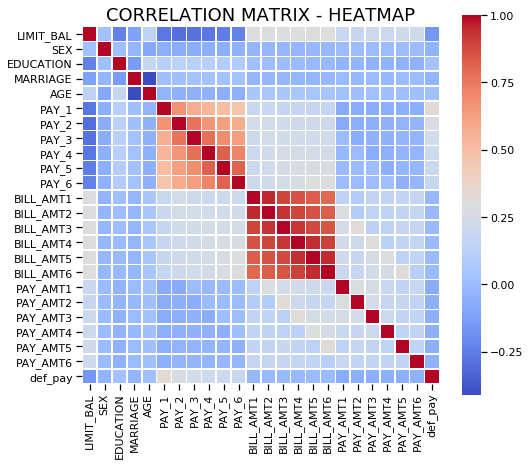

In [46]:
#  looking at correlations matrix, defined via Pearson function  
corr = df.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

La única característica con una notable correlación positiva con la variable  "Default" es el estado de pago durante el último mes (septiembre). 

La correlación negativa más alta con el incumplimiento se produce con Limit_Balance, lo que indica que los clientes con un saldo límite más bajo tienen más probabilidades de incumplimiento. También se puede observar que algunas variables están altamente correlacionadas entre sí, ese es el caso del monto del estado de cuenta y el estado de reembolso en diferentes meses.


El heatmat muestra que las características están correlacionadas entre sí (colinealidad), como PAY_0,2,3,4,5,6 y BILL_AMT1,2,3,4,5,6. En esos casos, la correlación es positiva.

# **Tecnicas de Balanceo Usada**

Si la base de datos esta desbalanceada,deben considerar el uso de tecnicas de submuestreo y sobremuestreo inteligente, ademas de usar validacíón ́estratificaida.

## **Stratified KFold**

In [47]:
from sklearn.model_selection import StratifiedKFold

#Train, Validation, Test
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS)
for train_index, test_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
  



TRAIN: [ 2993  2995  2996 ... 29997 29998 29999] TEST: [   0    1    2 ... 3004 3005 3006]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [2993 2995 2996 ... 6044 6045 6047]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [5985 5988 5989 ... 9034 9035 9036]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [ 8883  8886  8888 ... 12051 12052 12055]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [11794 11796 11802 ... 15072 15073 15074]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [14766 14770 14778 ... 18223 18224 18226]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [17316 17319 17323 ... 21199 21200 21201]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [20429 20437 20439 ... 24073 24074 24075]
TRAIN: [    0     1     2 ... 29997 29998 29999] TEST: [23691 23696 23704 ... 26998 26999 27000]
TRAIN: [    0     1     2 ... 26998 26999 27000] TEST: [27001 27002 27003 ... 29997 29998 29999]


## **Validación Booststrapping**

In [0]:
from sklearn.model_selection import train_test_split
VALID_SIZE = 0.20
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True )
print('X_Train', X_train.shape)
print('y_train', y_train.shape)


X_Train (24000, 23)
y_train (24000,)


## **Aprendizaje con balance de costo**

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
class_weights
#model.fit(X_train, y_train, class_weight=class_weights)


array([0.64201335, 2.26039783])

## **Stratified KFold con Class_weight** 

### **SMOTE**

In [0]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=589, ratio = 1.0)
X_SMOTE, y_SMOTE = sm.fit_sample(X, Y)
print(len(y_SMOTE))
print(y_SMOTE.sum())

46728
23364


In [0]:
X.values.shape

(30000, 23)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight


#Train, Validation, Test
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS)
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]    
    print("xTRAIN:", X_train.shape, "yTRAIN:", Y_train.shape)
    print("xTEST:", X_test.shape, "yTEST:", Y_test.shape)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    class_weightsTest = class_weight.compute_class_weight('balanced',np.unique(Y_test),Y_test)
    print("class_weightsTrain",(class_weightsTrain))
    print("class_weightsTest",class_weightsTest)   


xTRAIN: (26999, 23) yTRAIN: (26999,)
xTEST: (3001, 23) yTEST: (3001,)
class_weightsTrain [0.64200789 2.26046551]
class_weightsTest [0.64206247 2.25978916]
xTRAIN: (26999, 23) yTRAIN: (26999,)
xTEST: (3001, 23) yTEST: (3001,)
class_weightsTrain [0.64200789 2.26046551]
class_weightsTest [0.64206247 2.25978916]
xTRAIN: (26999, 23) yTRAIN: (26999,)
xTEST: (3001, 23) yTEST: (3001,)
class_weightsTrain [0.64200789 2.26046551]
class_weightsTest [0.64206247 2.25978916]
xTRAIN: (26999, 23) yTRAIN: (26999,)
xTEST: (3001, 23) yTEST: (3001,)
class_weightsTrain [0.64200789 2.26046551]
class_weightsTest [0.64206247 2.25978916]
xTRAIN: (27000, 23) yTRAIN: (27000,)
xTEST: (3000, 23) yTEST: (3000,)
class_weightsTrain [0.64200114 2.26054923]
class_weightsTest [0.64212329 2.25903614]
xTRAIN: (27000, 23) yTRAIN: (27000,)
xTEST: (3000, 23) yTEST: (3000,)
class_weightsTrain [0.64200114 2.26054923]
class_weightsTest [0.64212329 2.25903614]
xTRAIN: (27001, 23) yTRAIN: (27001,)
xTEST: (2999, 23) yTEST: (2999,)


# Modelos

### **Usando [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**

In [0]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

def modelTrain(model,params,X,Y,VALID_SIZE,FOLDS):
    skf = StratifiedKFold(n_splits=FOLDS)
    gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True, n_jobs=-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs.fit(X_train, Y_train)     
    return gs,X_test,Y_test

In [0]:
def Metrics(model,X_test,Y_test):

  y_predicted = model.predict(X_test)
  print('Accuracy: ', accuracy_score(Y_test, y_predicted), '\n')
  report = classification_report(Y_test, y_predicted)
  print("\nclassification report :\n",report )
 
  # Matriz de confusión
  plt.figure(figsize=(13,10))
  plt.subplot(221)
  sns.heatmap(confusion_matrix(Y_test, y_predicted),annot=True,fmt = "d",linecolor="k",linewidths=3)
  plt.title("Matriz de confusión",fontsize=20)
   
  # Curva ROC
  predicting_probabilites = model.predict_proba(X_test)[:,1]
  fpr,tpr,thresholds = roc_curve(Y_test, predicting_probabilites)
  plt.subplot(222)
  plt.plot(fpr,tpr,label = ("Área bajo la curva:",auc(fpr,tpr)),color = "r")
  plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
  plt.legend(loc = "best")
  plt.title("Curva ROC",fontsize=20)
  return report

In [0]:
def printMetrics(result):
  results = pd.DataFrame(result.cv_results_)
  print(results[['mean_test_score','std_test_score','mean_train_score','std_train_score']])  


## **Na ̈ıve Bayes**

[Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
VALID_SIZE = 0.20
FOLDS = 10
params = {}

gsGaussianNB,X_test,Y_test = modelTrain(gnb,params,X,Y,VALID_SIZE,FOLDS)

#GUARDAR MODELO
#joblib.dump(gsGaussianNB, PATH+'Models/gsGaussianNB.pkl')

In [0]:
#READ MODEL 

PATHGNBMODEL = PATH+'Models/gsGaussianNB.pkl'
gsGaussianNB = joblib.load(PATHGNBMODEL)


### **Resultado Obtenidos**

Recuerde que como parte de una correcta metodolog ́ıa de validacion se deben incluir, seg  ́ un sea el caso, medidas de sensibilidad, especificidad, eficiencia, matriz de confusion, error cuadratico medio, MAPE, coeficiente de determinacion, etc., Deben incluir intervalos de confianza para todas las medidas usadas.

Accuracy:  0.6875 


classification report :
               precision    recall  f1-score   support

           0       0.89      0.69      0.78      4703
           1       0.38      0.69      0.49      1297

    accuracy                           0.69      6000
   macro avg       0.63      0.69      0.63      6000
weighted avg       0.78      0.69      0.71      6000

   mean_test_score  std_test_score  mean_train_score  std_train_score
0         0.679875        0.041991          0.678551          0.03826


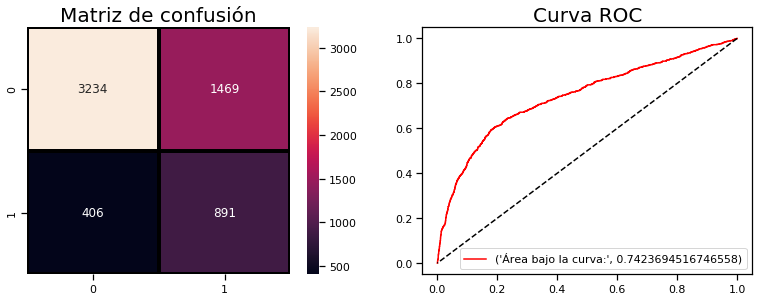

In [54]:
metrics = Metrics(gsGaussianNB.best_estimator_,X_test,Y_test)
printMetrics(gsGaussianNB)

**Sensibilidad** = tp / (tp + fn)


**Especificidad**  = tn /(tn+fp)


**eficiencia** = tp+tn/(tp+tn+fp+fn)


**Precisión** = tp /(tp+fp)




## **Random Forest**

[Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [0]:
from sklearn.ensemble import RandomForestClassifier

VALID_SIZE = 0.20
FOLDS = 10

"""
params = { 
    'n_estimators': [50,100,150,200,250,300],
     "max_features": [1,2,3,4,5,6,7,8,9,10],
     'max_depth': [1,2,3,4,5,6,7,8,9],
    'criterion' :['gini', 'entropy']
}
"""
params = { 
    'n_estimators': [10,20,30,40,50],
     "max_features": [1,2,3,4,5],
     'max_depth': [1,2,3,4,5,8,10,15,20],
    'criterion' :['gini', 'entropy']
}


rfc=RandomForestClassifier()

gsRDF,X_test,Y_test= modelTrain(rfc,params,X,Y,VALID_SIZE,FOLDS)

print("Best SCORE",gsRDF.best_score_)
print("Best ESTIMATOR", gsRDF.best_params_)


#GUARDAR MODELO
PATH_gsRDF_MODEL = PATH+'Models/gsRDF.pkl'
joblib.dump(gsRDF,PATH_gsRDF_MODEL)

Best SCORE 0.8196666666666667
Best ESTIMATOR {'criterion': 'entropy', 'max_depth': 8, 'max_features': 5, 'n_estimators': 50}


['/content/drive/My Drive/2019-1/Simulation of System and Laboratory/Final Project/Code/Models/gsRDF.pkl']

### **Resultado Obtenidos**

Recuerde que como parte de una correcta metodolog ́ıa de validacion se deben incluir, seg  ́ un sea el caso, medidas de sensibilidad, especificidad, eficiencia, matriz de confusion, error cuadratico medio, MAPE, coeficiente de determinacion, etc., Deben incluir intervalos de confianza para todas las medidas usadas.

Accuracy:  0.8263333333333334 


classification report :
               precision    recall  f1-score   support

           0       0.84      0.95      0.90      4697
           1       0.69      0.36      0.48      1303

    accuracy                           0.83      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.83      0.80      6000

     mean_test_score  std_test_score  mean_train_score  std_train_score
0           0.777792        0.000136          0.777792         0.000015
1           0.777792        0.000136          0.777792         0.000015
2           0.777792        0.000136          0.777792         0.000015
3           0.777792        0.000136          0.777792         0.000015
4           0.777792        0.000136          0.777792         0.000015
5           0.778750        0.002920          0.778380         0.001759
6           0.778083        0.000817          0.778028         0.000716
7           0.777792        0.000136   

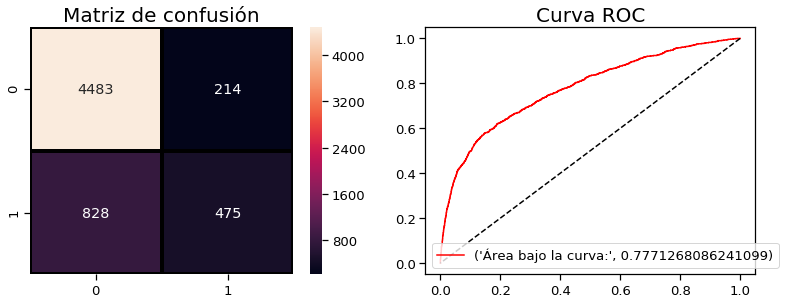

In [0]:
metrics = Metrics(gsRDF.best_estimator_,X_test,Y_test)
printMetrics(gsRDF)

In [0]:
#READ MODEL 

PATHRDFMODEL = PATH+'Models/gsRDF.pkl'
gsRDF = joblib.load(PATHRDFMODEL)



 ---




## K vecinos mas cercanos

[Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [55]:
from sklearn.neighbors import KNeighborsClassifier

VALID_SIZE = 0.20
FOLDS = 10
params = {
    'n_neighbors':[3,5,7,9,11],
    'metric':['minkowski','euclidean','manhattan']
    
    
}
KNN = KNeighborsClassifier()


gsKNN,X_test,Y_test = modelTrain(KNN,params,X,Y,VALID_SIZE,FOLDS)


Best SCORE 0.8088333333333333


AttributeError: ignored

In [56]:
print("Best SCORE",gsKNN.best_score_)
print("Best ESTIMATOR", gsKNN.best_params_)

#GUARDAR MODELO
PATH_knn_MODEL = PATH+'Models/gsKNN.pkl'
joblib.dump(gsKNN,PATH_knn_MODEL)

Best SCORE 0.8088333333333333
Best ESTIMATOR {'metric': 'minkowski', 'n_neighbors': 11}


['/content/drive/My Drive/2019-1/Simulation of System and Laboratory/Final Project/Code/Models/gsKNN.pkl']

### **Resultado Obtenidos**

Recuerde que como parte de una correcta metodolog ́ıa de validacion se deben incluir, seg  ́ un sea el caso, medidas de sensibilidad, especificidad, eficiencia, matriz de confusion, error cuadratico medio, MAPE, coeficiente de determinacion, etc., Deben incluir intervalos de confianza para todas las medidas usadas.

Accuracy:  0.8053333333333333 


classification report :
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4667
           1       0.61      0.34      0.43      1333

    accuracy                           0.81      6000
   macro avg       0.72      0.64      0.66      6000
weighted avg       0.78      0.81      0.78      6000

    mean_test_score  std_test_score  mean_train_score  std_train_score
0          0.777458        0.004741          0.866523         0.000795
1          0.792167        0.005404          0.845153         0.001155
2          0.800167        0.005639          0.835903         0.000803
3          0.806500        0.005417          0.831162         0.001041
4          0.808833        0.007486          0.827880         0.001473
5          0.777458        0.004741          0.866523         0.000795
6          0.792167        0.005404          0.845153         0.001155
7          0.800167        0.005639          0.

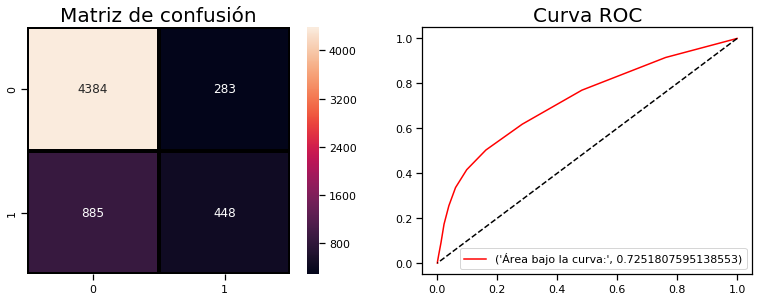

In [57]:
metrics = Metrics(gsKNN.best_estimator_,X_test,Y_test)
printMetrics(gsKNN)



---




## **Redes Neuronales Artificiales**

### **Resultado Obtenidos**

Recuerde que como parte de una correcta metodolog ́ıa de validacion se deben incluir, seg  ́ un sea el caso, medidas de sensibilidad, especificidad, eficiencia, matriz de confusion, error cuadratico medio, MAPE, coeficiente de determinacion, etc., Deben incluir intervalos de confianza para todas las medidas usadas.



 ---




## **Maquinas de Soporte Vectorial con kernel lineal y con kernel RBF.**

In [0]:
from sklearn.svm import SVC

VALID_SIZE = 0.20
FOLDS = 10

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf','linear']

params = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
svm = SVC()
gsSVM = modelTrain(svm,params,X,Y,VALID_SIZE,FOLDS)

print("Best SCORE",gsSVM.best_score_)
print("Best ESTIMATOR", gsSVM.best_params_)



#GUARDAR MODELO
PATH_svm_MODEL = PATH+'Models/gsSVM.pkl'
joblib.dump(gsSVM,PATH_svm_MODEL)


### **Resultado Obtenidos**

Recuerde que como parte de una correcta metodolog ́ıa de validacion se deben incluir, seg  ́ un sea el caso, medidas de sensibilidad, especificidad, eficiencia, matriz de confusion, error cuadratico medio, MAPE, coeficiente de determinacion, etc., Deben incluir intervalos de confianza para todas las medidas usadas.



 ---


